In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import RobustScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sys
sys.path.append('../src/bars')
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')
from ImbalanceVolumeBars import ImbalanceVolumeBars

In [ ]:
time_bars = pd.read_csv('../data/msft.csv', parse_dates=['date'], index_col='date')

# 📶 Creating Indicators
To support the model training process, I will incorporate two commonly used technical indicators: **Bollinger Bands** and **Average True Range (ATR)**.

In [ ]:
def bollinger_bands(data, window_size, std_interval=2):
    ma = data.rolling(window_size).mean()
    std = data.rolling(window_size).std()
    upper = ma + std * std_interval
    lower = ma - std * std_interval
    
    return ma, upper, lower

In [ ]:
def average_true_range(high, low, close, window_size=int, method='sma'):
    close_t_minus_one = close.shift(1)
    hl = high - low
    hc = abs(high-close_t_minus_one)
    lc = abs(low - close_t_minus_one)
    tr = np.maximum(np.maximum(hl, hc), lc)

    if method=='sma':
        atr = tr.rolling(window_size).mean()
    elif method=='ewm':
        atr = tr.ewm(alpha=1/window_size, adjust=False).mean()
    else:
        raise ValueError("method must be 'sma' or 'ewm'")
        
    return atr

In [ ]:
b_up, b_down, b_mean = bollinger_bands(time_bars['close'], window_size=7)
time_bars['boll_up'] = b_up
time_bars['boll_down'] = b_down
time_bars['boll_mean'] = b_mean

In [ ]:
high = time_bars['high']
low = time_bars['low']
close = time_bars['close']
atr = average_true_range(high, low, close, window_size=7)
time_bars['atr'] = atr

## ⚓ Resampling data

In [ ]:
ivb_resampler = ImbalanceVolumeBars(time_bars)
iv_bars = ivb_resampler.make_bars(alpha=.5)
iv_bars.columns = iv_bars.columns.str.lower()

In [ ]:
iv_index = iv_bars.index
iv_indicators = time_bars[np.isin(time_bars.index, iv_index)]
iv_indicators = iv_indicators.drop(columns=['open', 'high', 'low', 'close', 'volume', 'average'])

In [ ]:
iv_bars = pd.concat([iv_bars, iv_indicators], axis=1)

In [ ]:
time_logs = np.log((time_bars['close'] / time_bars['close'].shift(1)))
ivb_logs = np.log((iv_bars['close'] / iv_bars['close'].shift(1)))

In [ ]:
time_bars['logs'] = time_logs
iv_bars['logs'] = ivb_logs

time_bars = time_bars.dropna().drop(columns=['open', 'high', 'low', 'close','average', 'barCount'])
iv_bars = iv_bars.dropna().drop(columns=['open', 'high', 'low', 'close', 'barCount'])

In [ ]:
print(time_bars.columns)
print(iv_bars.columns)

Index(['volume', 'boll_up', 'boll_down', 'boll_mean', 'atr', 'logs'], dtype='object')
Index(['volume', 'boll_up', 'boll_down', 'boll_mean', 'atr', 'logs'], dtype='object')


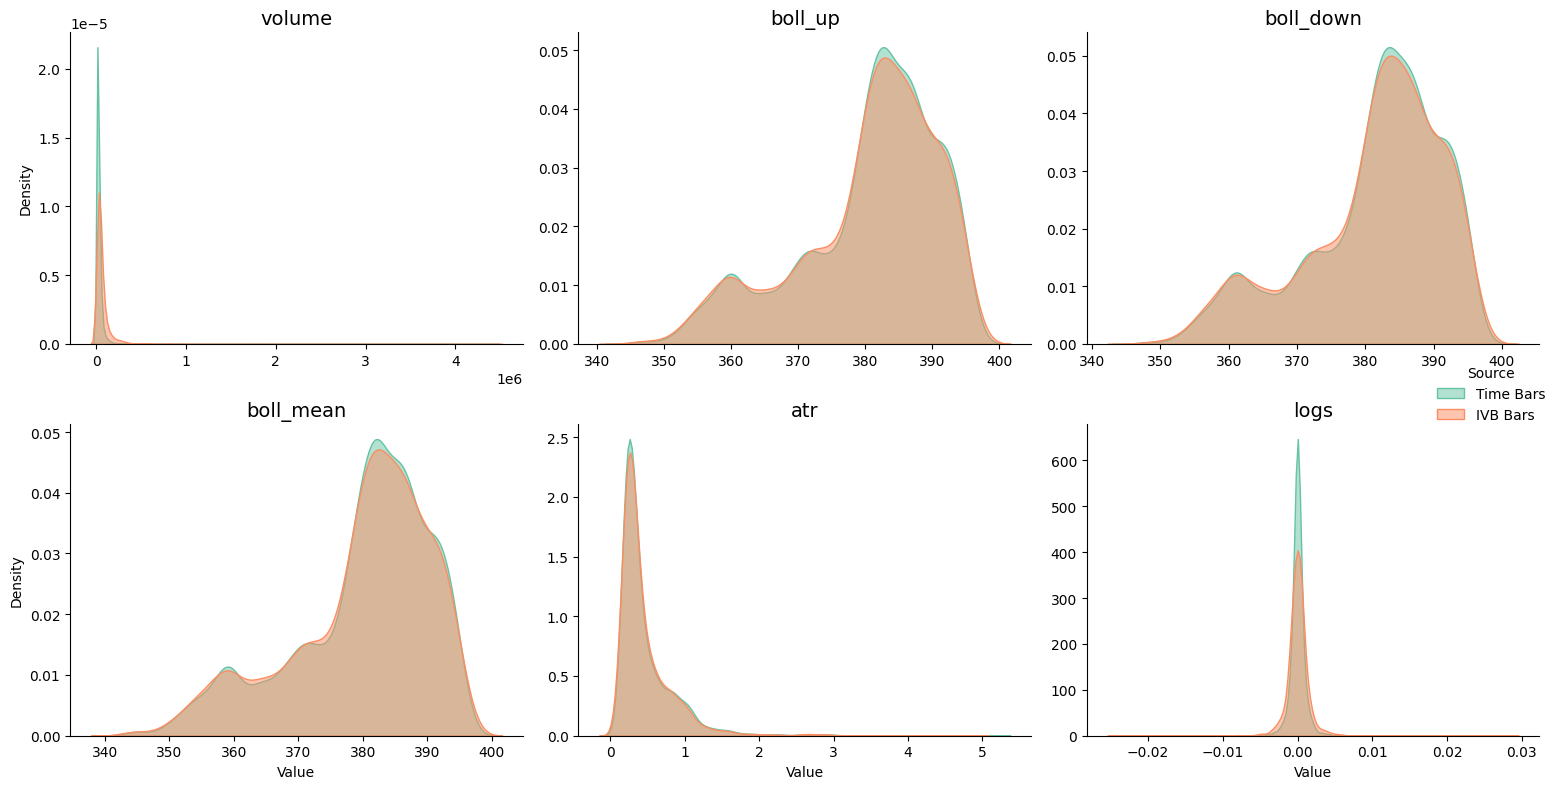

In [ ]:
time_bars['Source'] = 'Time Bars'
iv_bars['Source'] = 'IVB Bars'

time_bars_melted = time_bars.melt(id_vars='Source', var_name='Feature', value_name='Value')
iv_bars_melted = iv_bars.melt(id_vars='Source', var_name='Feature', value_name='Value')

combined_df = pd.concat([time_bars_melted, iv_bars_melted])

g = sns.FacetGrid(
    combined_df,
    col='Feature',
    col_wrap=3,
    height=4,
    aspect=1.2,
    sharex=False,
    sharey=False,
    hue='Source',
    palette='Set2'
)

g.map(sns.kdeplot, 'Value', fill=True, common_norm=False, alpha=0.5)
g.add_legend()

g.set_titles("{col_name}", size=14)
g.set_axis_labels("Value", "Density")
plt.tight_layout()
plt.show()

In [ ]:
time_bars = time_bars.drop(columns='Source')
iv_bars = iv_bars.drop(columns='Source')

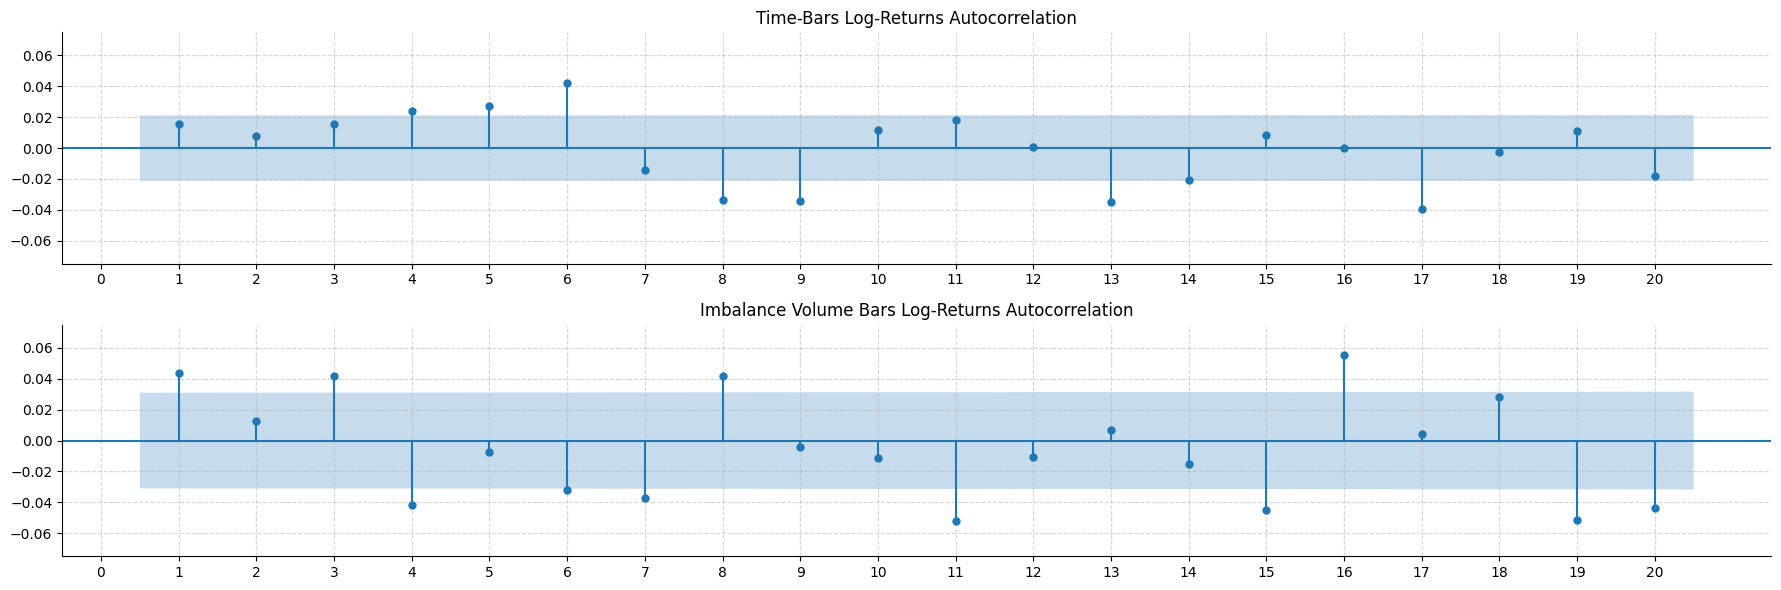

In [ ]:
ylim = (-0.075, 0.075)
xticks = range(0,21, 1)

fig, ax = plt.subplots(2,1, figsize=(18,6))

plot_acf(time_bars['logs'], lags=20, zero=False, ax=ax[0])
ax[0].set_xticks(xticks)
ax[0].set_ylim(ylim)
ax[0].set_title('Time-Bars Log-Returns Autocorrelation')
ax[0].grid(ls='--', alpha=.5)

plot_acf(iv_bars['logs'], lags=20, zero=False, ax=ax[1])
ax[1].set_xticks(xticks)
ax[1].set_ylim(ylim)
ax[1].set_title('Imbalance Volume Bars Log-Returns Autocorrelation')
ax[1].grid(ls='--', alpha=.5)

sns.despine()
plt.tight_layout()
plt.show()

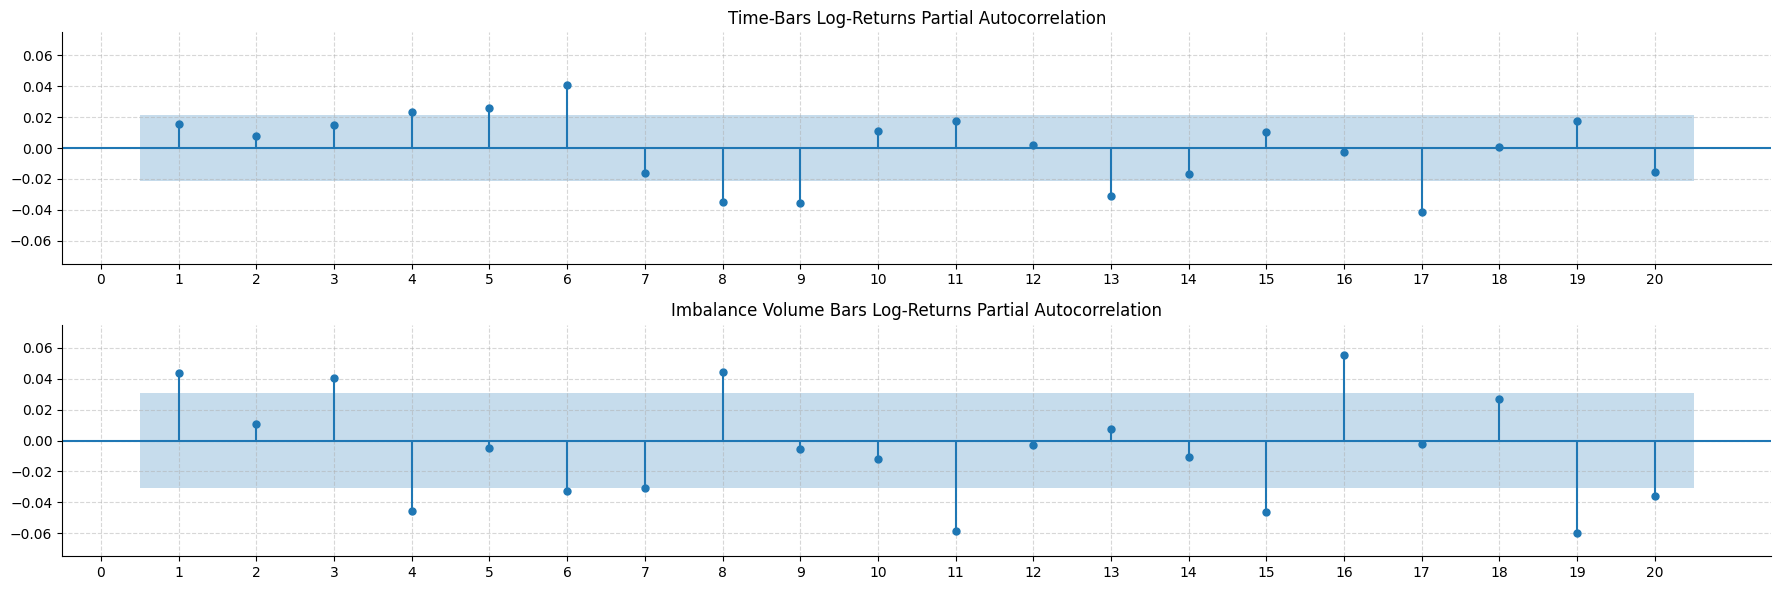

In [ ]:
ylim = (-0.075, 0.075)
xticks = range(0,21, 1)

fig, ax = plt.subplots(2,1, figsize=(18,6))

plot_pacf(time_bars['logs'], lags=20, zero=False, ax=ax[0])
ax[0].set_xticks(xticks)
ax[0].set_ylim(ylim)
ax[0].set_title('Time-Bars Log-Returns Partial Autocorrelation')
ax[0].grid(ls='--', alpha=.5)

plot_pacf(iv_bars['logs'], lags=20, zero=False, ax=ax[1])
ax[1].set_xticks(xticks)
ax[1].set_ylim(ylim)
ax[1].set_title('Imbalance Volume Bars Log-Returns Partial Autocorrelation')
ax[1].grid(ls='--', alpha=.5)

sns.despine()
plt.tight_layout()
plt.show()

# 🌐 Preprocessing for XGBoost

In [ ]:
# Creating a sliding-dindows generator:
def make_windows(x, y, window_size):
    x_windows = np.array([x[i: i + window_size] for i in range(len(x) - window_size)])
    y_labels = np.array([y[i + window_size] for i in range(len(y) - window_size)])
    return x_windows, y_labels

# creating a time-series train-test splitter:
def train_test_time_series(x, y, test_size=0.2):
    train_size = int((1-test_size)*len(x))
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return x_train, x_test, y_train, y_test

In [ ]:
# Splitting the data into features and targets
t_features, t_target = time_bars.drop(columns='logs'), time_bars['logs']
iv_features, iv_target = iv_bars.drop(columns='logs'), iv_bars['logs']

In [ ]:
# Creating windows
time_windows, time_labels = make_windows(t_features, t_target, 7)
ivb_windows, ivb_labels = make_windows(iv_features, iv_target, 7)

In [ ]:
print(time_windows.shape, time_labels.shape)
print(ivb_windows.shape, ivb_labels.shape)

(8566, 7, 5) (8566,)
(3988, 7, 5) (3988,)


In [ ]:
# Creating train and test sets
tx_train, tx_test, ty_train, ty_test = train_test_time_series(time_windows, time_labels)
ivx_train, ivx_test, ivy_train, ivy_test = train_test_time_series(ivb_windows, ivb_labels)

In [ ]:
print(f'time train shapes: {tx_train.shape, ty_train.shape}')
print(f'time test shapes: {tx_test.shape, ty_test.shape}')
print()
print(f'ivb train shapes: {ivx_train.shape, ivy_train.shape}')
print(f'time test shapes: {ivx_test.shape, ivy_test.shape}')

time train shapes: ((6852, 7, 5), (6852,))
time test shapes: ((1714, 7, 5), (1714,))

ivb train shapes: ((3190, 7, 5), (3190,))
time test shapes: ((798, 7, 5), (798,))


In [ ]:
tx_train_flat = tx_train.reshape(tx_train.shape[0], -1)
tx_test_flat = tx_test.reshape(tx_test.shape[0], -1)
ivx_train_flat = ivx_train.reshape(ivx_train.shape[0], -1)
ivx_test_flat = ivx_test.reshape(ivx_test.shape[0], -1)

In [ ]:
print(f'time train shapes: {tx_train_flat.shape, ty_train.shape}')
print(f'time test shapes: {tx_test_flat.shape, ty_test.shape}')
print()
print(f'ivb train shapes: {ivx_train_flat.shape, ivy_train.shape}')
print(f'time test shapes: {ivx_test_flat.shape, ivy_test.shape}')

time train shapes: ((6852, 35), (6852,))
time test shapes: ((1714, 35), (1714,))

ivb train shapes: ((3190, 35), (3190,))
time test shapes: ((798, 35), (798,))


## 📏 Rescaling the Data
As observed earlier, our features deviate significantly from a normal distribution.  
Therefore, it may be more appropriate to use the ```RobustScaler```, which is better suited for handling non-normal data distributions.

In [ ]:
t_scaler = RobustScaler()
tx_train_scaled = t_scaler.fit_transform(tx_train_flat)
tx_test_scaled = t_scaler.transform(tx_test_flat)

In [ ]:
iv_scaler = RobustScaler()
ivx_train_scaled = iv_scaler.fit_transform(ivx_train_flat)
ivx_test_scaled = iv_scaler.transform(ivx_test_flat)

# 📌 HyperParameter Fine-Tuning
Hyperparameter fine-tuning is one of the most critical steps when training machine learning algorithms, as it can significantly impact model performance — especially in models like XGBoost, which involve a large number of tunable parameters.  

To optimize the model’s hyperparameters, I will use the ```optuna``` library.  

Since this notebook aims to demonstrate key concepts rather than fully execute the predictive modeling workflow, I will limit the hyperparameter optimization process to five minutes (300 seconds) per model.

In [ ]:
def create_objective(x_train, y_train):
    def objective(trial):
        params = {
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        }
        
        model = XGBRegressor(
            **params,
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            verbosity=0,
            random_state=42,
            n_jobs=-1
        )

        tscv = TimeSeriesSplit(n_splits=3)
        score = cross_val_score(
            model, 
            x_train, 
            y_train, 
            cv=tscv, 
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        
        return -score.mean()
    
    return objective

In [ ]:
pruner = optuna.pruners.HyperbandPruner()
study_time = optuna.create_study(direction='minimize', pruner=pruner, study_name='time')
study_time.optimize(create_objective(tx_train_scaled, ty_train), timeout=300) 

In [ ]:
study_ivb = optuna.create_study(direction='minimize', pruner=pruner, study_name='volume')
study_ivb.optimize(create_objective(ivx_train_scaled, ivy_train), timeout=300)

In [ ]:
time_best_params = study_time.best_params
ivb_best_params = study_ivb.best_params
print("Best parameters for Time Bars:", time_best_params)
print("Best parameters for Volume Bars (IVB):", ivb_best_params)

Best parameters for Time Bars: {'learning_rate': 0.010382650670427677, 'max_depth': 8, 'subsample': 0.7543881609285196, 'colsample_bytree': 0.980654457464814, 'n_estimators': 50}
Best parameters for Volume Bars (IVB): {'learning_rate': 0.011006713557872602, 'max_depth': 3, 'subsample': 0.6347058709758384, 'colsample_bytree': 0.6992201153236518, 'n_estimators': 60}


## ⚙️ Training the XGB Regressors

In [ ]:
time_xgb = XGBRegressor(**time_best_params,
                        n_jobs=1)
ivb_xgb = XGBRegressor(**ivb_best_params,
                       n_jobs=16)

In [ ]:
time_xgb.fit(tx_train_scaled, ty_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.980654457464814, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010382650670427677,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=1,
             num_parallel_tree=None, ...)

In [ ]:
ivb_xgb.fit(ivx_train_scaled, ivy_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6992201153236518, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.011006713557872602,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=60, n_jobs=16,
             num_parallel_tree=None, ...)

In [ ]:
time_xgb_pred = time_xgb.predict(tx_test_scaled)
ivb_xgb_pred = ivb_xgb.predict(ivx_test_scaled)

## 🔬 Models Evaluation

In [ ]:
def evaluate_model(y_true, y_pred):
    metrics = {
        'MSE': round(mean_squared_error(y_true, y_pred), 5),
        'MAE': round(mean_absolute_error(y_true, y_pred), 5),
        'R^2': round(r2_score(y_true, y_pred), 5)
    }
    return metrics

In [ ]:
time_xgb_results = evaluate_model(ty_test, time_xgb_pred)
ivb_xgb_results = evaluate_model(ivy_test, ivb_xgb_pred)

In [ ]:
print(time_xgb_results)
print(ivb_xgb_results)

{'MSE': 1e-05, 'MAE': 0.00141, 'R^2': -0.00481}
{'MSE': 1e-05, 'MAE': 0.00212, 'R^2': 0.01367}


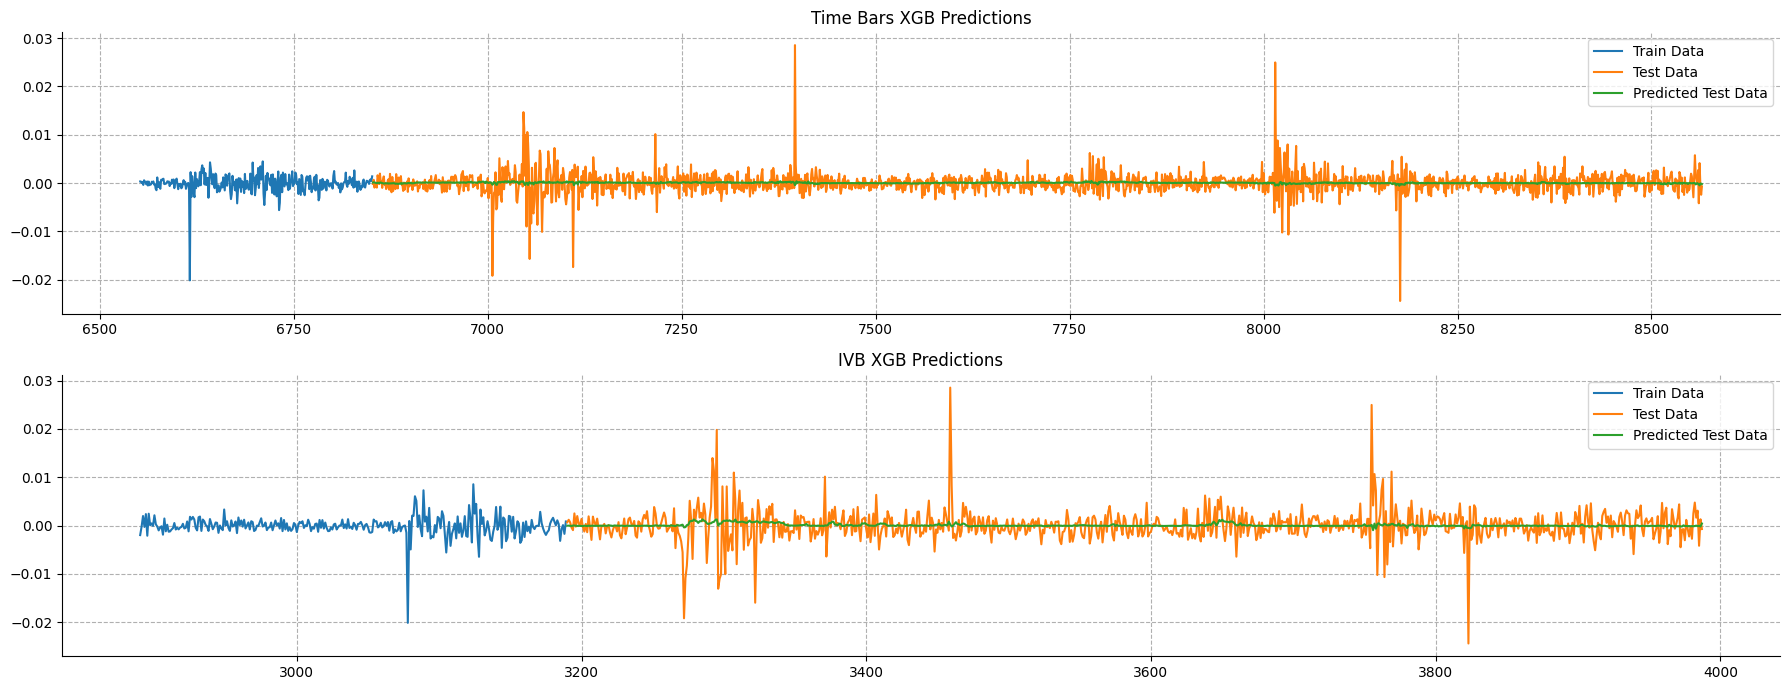

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(18, 7))

t_train_len = len(ty_train)
t_test_len = len(ty_test)
iv_train_len = len(ivy_train)
iv_test_len = len(ivy_test)

SHOW_TRAIN = 300

ax[0].plot(range(t_train_len - SHOW_TRAIN, t_train_len), ty_train[-SHOW_TRAIN:], label='Train Data')
ax[0].plot(range(t_train_len, t_train_len + t_test_len), ty_test, label='Test Data')
ax[0].plot(range(t_train_len, t_train_len + t_test_len), time_xgb_pred, label='Predicted Test Data')
ax[0].grid(ls='--')
ax[0].legend()
ax[0].set_title('Time Bars XGB Predictions')

ax[1].plot(range(iv_train_len - SHOW_TRAIN, iv_train_len), ivy_train[-SHOW_TRAIN:], label='Train Data')
ax[1].plot(range(iv_train_len, iv_train_len + iv_test_len), ivy_test, label='Test Data')
ax[1].plot(range(iv_train_len, iv_train_len + iv_test_len), ivb_xgb_pred, label='Predicted Test Data')
ax[1].grid(ls='--')
ax[1].legend()
ax[1].set_title('IVB XGB Predictions')

sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
time_residuals = ty_test - time_xgb_pred
ivb_residuals = ivy_test - ivb_xgb_pred

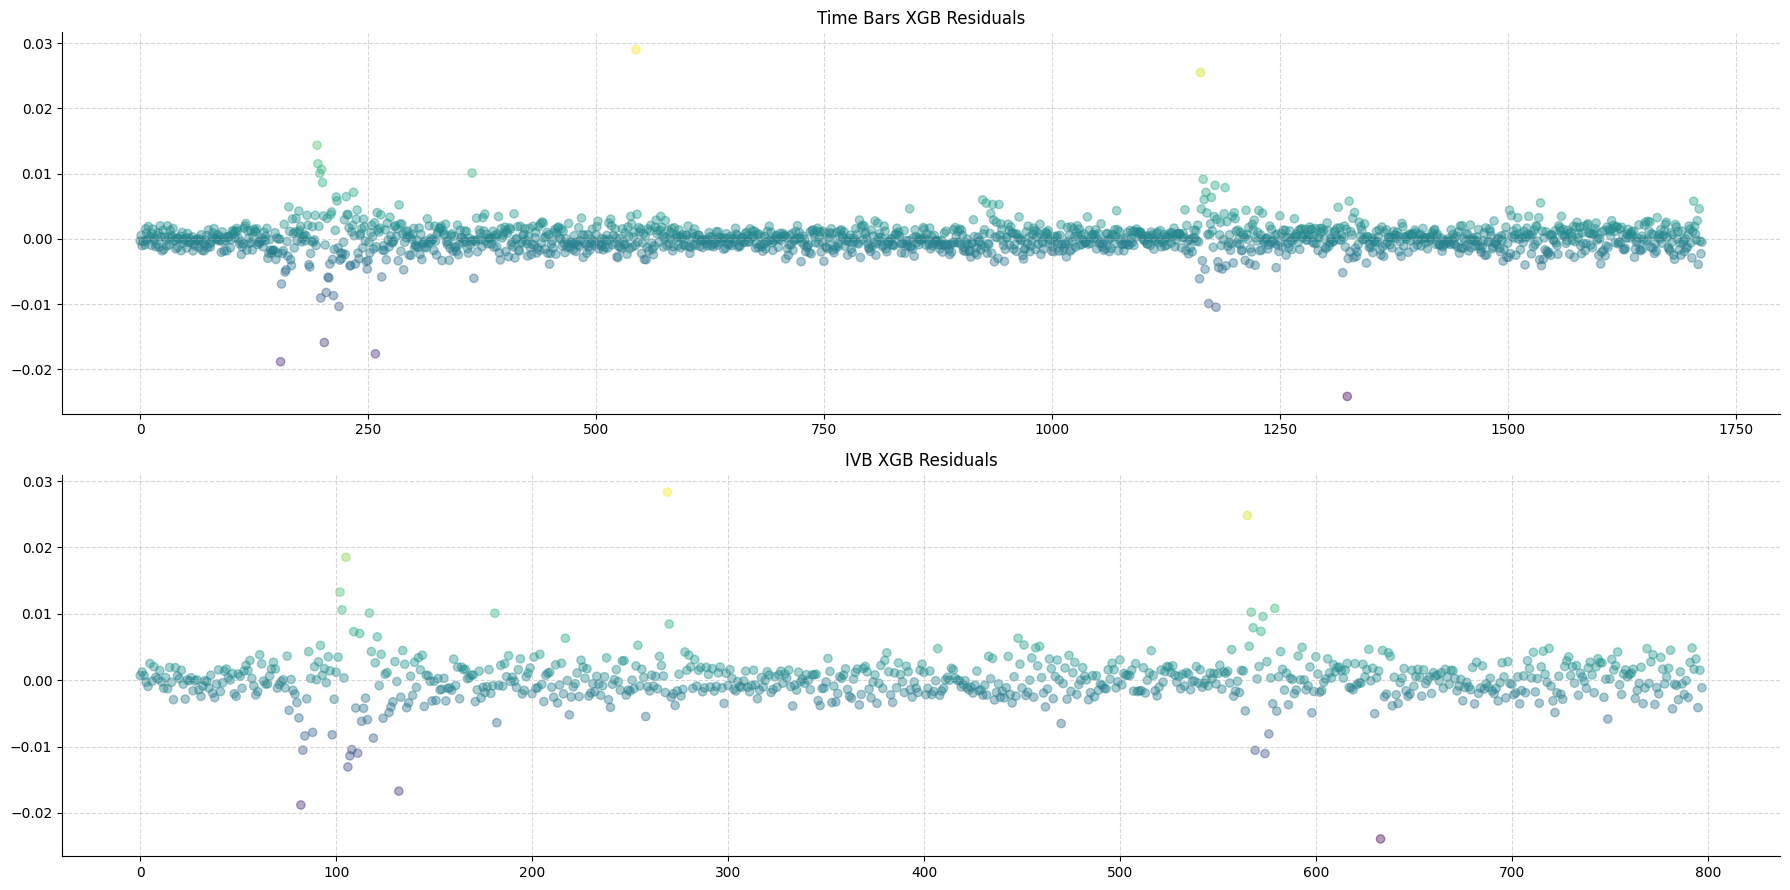

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(18,9))
ax[0].scatter(range(len(time_residuals)), time_residuals,
              alpha=.4, c=time_residuals)
ax[0].grid(ls='--', alpha=.5)
ax[0].set_title('Time Bars XGB Residuals')

ax[1].scatter(range(len(ivb_residuals)), ivb_residuals,
             alpha=.4, c=ivb_residuals)
ax[1].grid(ls='--', alpha=.5)
ax[1].set_title('IVB XGB Residuals')

sns.despine()
plt.tight_layout()
plt.show()

## 📈 Findings
During the experiment, the forecasting capabilities of the XGBoost model were evaluated on time series processed using two different sampling methods: **Time Bars** and **Imbalance Volume Bars (IVB)**.  
In the Time Bars case, the model achieved a slightly negative \( R^2 \) value, while in the IVB case it achieved a slightly positive \( R^2 \) value.  
Although the absolute values of \( R^2 \) remained close to zero, the transition to IVB sampling reflects a measurable improvement, suggesting a marginally better ability to capture predictive patterns compared to traditional time-based sampling.

## 🧠 Discussion
The results align with the well-known difficulty of forecasting log returns, which are highly volatile and predominantly driven by noise.  
Achieving even a small positive \$( R^2 \$) is considered a non-trivial accomplishment in this context, indicating that the model was able to detect a weak but real predictive structure amidst substantial random variation.  
The slight improvement observed with IVB sampling highlights the potential of alternative sampling techniques to enhance the learning process, albeit modestly.  
Nonetheless, the overall low \$( R^2 \$) values underscore the inherent limitations in the predictability of high-frequency financial time series, particularly when relying on a small set of features and standard modeling approaches.

## ⚠️ Limitations of This Work
1. The experiment was conducted on a single time series with a fixed window size. No generalization was made across multiple assets, periods, window sizes, or different alpha levels during IVB sampling.
2. The XGBoost model, while powerful, is not specifically tailored for modeling stochastic or sequential processes, which may restrict its ability to fully capture the dynamics of financial time series.
3. Feature engineering was limited to only two basic technical indicators. Incorporating a broader, more sophisticated set of features — and analyzing their interactions — could reveal stronger predictive signals and potentially improve model performance.

## 🚀 Next Steps
1. **Expand the Analysis Across Multiple Assets:** Testing the methodology across a diverse range of instruments, market regimes, and timeframes could help assess the generalizability of the findings.
2. **Enhance Feature Engineering:** Introducing a richer set of technical, statistical, and volume-based indicators — and exploring their interactions — may significantly improve the model’s predictive capabilities.
3. **Experiment with Alternative Models:** Exploring models better suited to sequential data, such as recurrent neural networks (RNNs), Temporal Convolutional Networks (TCNs), or Transformer-based architectures, could capture deeper temporal dependencies.
4. **Optimize Sampling Parameters:** Conduct a systematic exploration of different window sizes and alpha thresholds in the IVB sampling process to identify more effective configurations.
5. **Incorporate Target Engineering:** Instead of directly forecasting raw log returns, consider framing the task as a classification problem (e.g., predicting the direction of the next return), which may yield stronger signals in noisy financial environments.
